In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg

from params import *
from events_coupling import event_coupling_job, concat_events_coupling_job
from rsp_detection import resp_tag_job
from circular_stats import HR2P
from configuration import base_folder

# STATS & PLOT TOOLS

In [3]:
def get_circ_features(angles, univals=1000, seed=None, progress_bar = False): # angles in radians
    pval = HR2P(angles, univals=univals, seed=seed, progress_bar=progress_bar)

    mu = pg.circ_mean(angles) #+ np.pi
    mu = int(np.degrees(mu))
    r = round(pg.circ_r(angles), 3)

    if mu < 0:
        mu = 360 + mu

    return pval, mu, r

def pval_stars(p):
    if not np.isnan(p):
        if p >= 0.05:
            stars = 'ns'
        elif p < 0.05 and p >= 0.01:
            stars = '*'
        elif p < 0.01 and p >= 0.001:
            stars = '**'
        elif p < 0.001:
            stars = '***'
    else:
        stars = np.nan
    return stars

def load_angles(event, subject = '*', stage = '*', cooccuring = '*', speed = '*', chan = '*', quart_night = '*'):

    """
    High level function that load angles according to arguments and concatenate them if '*' argument

    Parameters (str)
    ----------
    event : 'Spindles' or 'SlowWaves'
    subject : From 'S1' to 'S20', '*' to concatenate all
    stage : 'N2' or 'N3, or '*' to concatenate all
    cooccuring : 'cooccur' or 'notcoocur', '*' to concatenate both
    speed : 'SS' or 'FS' for slow or fast spindles, '*' to concatenate both (useful only for spindles)
    quart_night : 'firsthalf' ot 'secondhalf' of night, '*' to concatenate both
    chan : 'Fz' for example or '*' to concatenate all
    """

    if subject == '*':
        df_angles = concat_events_coupling_job.get('global_key').to_dataframe()
    else:
        df_angles = event_coupling_job.get(subject).to_dataframe()

    df_angles = df_angles[df_angles['Event_type'] == event]

    if cooccuring == '*':
        mask_cooccuring = df_angles['cooccuring'].isin(df_angles['cooccuring'].unique())
    else:
        mask_cooccuring = df_angles['cooccuring'] == cooccuring
        
    if stage == '*':
        mask_stage = df_angles['Stage_Letter'].isin(df_angles['Stage_Letter'].unique())
    else:
        mask_stage = df_angles['Stage_Letter'] == stage        
    
    if speed == '*':
        mask_speed = df_angles['Sp_Speed'].isin(df_angles['Sp_Speed'].unique())
    else:
        mask_speed = df_angles['Sp_Speed'] == speed

    if chan == '*':
        mask_chan = df_angles['Channel'].isin(df_angles['Channel'].unique())
    else:
        mask_chan = df_angles['Channel'] == chan

    if quart_night == '*':
        mask_night = df_angles['night_quartile'].isin(df_angles['night_quartile'].unique())
    else:
        mask_night = df_angles['night_quartile'] == quart_night

    if event == 'Spindles':
        mask =  mask_stage & mask_cooccuring & mask_speed & mask_chan & mask_night 
    elif event == 'SlowWaves':
        mask = mask_stage & mask_cooccuring & mask_chan & mask_night 

    df_angles = df_angles[mask]

    return df_angles['Resp_Angle'].values

def circular_plot_angles(
    angles, 
    color = None, 
    ax=None, 
    ratio_plot = 0.42, 
    bins = 18, 
    with_rticks = True, 
    with_title = False, 
    with_arrow = True, 
    polar_ticks = 'full',
    lw = 10,
    progress_bar = False,
    univals= 100,
    seed = None,
    with_stats = True):

    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection = 'polar'), constrained_layout = True)
    if with_stats:
        pval, mu , r = get_circ_features(angles, univals=univals, seed=seed, progress_bar=progress_bar)
        stars = pval_stars(pval)

    N_events = angles.size # number of angles computed and distributed = number of events detected and computed (all subjects pooled)
    values, bins_hist, patches = ax.hist(angles, bins = bins, density = True, edgecolor = 'black', color = color ) # polar histogram of distribution of angles of all subjects (in radians)
    rmax = np.max(values)
    max_rticks = rmax + 0.05 * rmax

    if with_rticks:
        ax.set_rticks(np.arange(0,max_rticks,0.05))
        ax.set_rmax(max_rticks)
    else:
        ax.set_rticks([])

    step = np.pi / 180
    theta_inspi = np.arange(0, ratio_plot * 2*np.pi, step)
    theta_expi = np.arange(ratio_plot * 2*np.pi, 2*np.pi, step)
    for theta, color in zip([theta_inspi, theta_expi],['r','k']):
        r_plot = np.ones(theta.size) * rmax * 1.05
        ax.plot(theta, r_plot, lw = lw, color =color)
    
    if polar_ticks == 'full':
        ax.set_xticks(np.deg2rad([0, 90 , ratio_plot * 360 , 180 , 270])) # at this angles in degrees, ticks labels will be present
        ax.set_xticklabels(['Start', '90°', 'I>E', '180°','270°']) # labelize polar plot angles
    elif polar_ticks == 'light':
        ax.set_xticks([ratio_plot * 2*np.pi]) # at this angles in degrees, ticks labels will be present
        ax.set_xticklabels(['I>E']) # labelize polar plot angles
    
    if with_title :
        if with_stats:
            ax.set_title(f'N : {N_events} \n Mean Angle : {mu}° - MVL : {r} \n p-HermansRasson : {stars}')
        else:
            ax.set_title(f'N : {N_events}')
    if with_stats:
        if with_arrow:
            # if N_events > 1000:
            #     color_arrow = 'red'
            # else:
            #     color_arrow = 'red'
            color_arrow = 'red'
            ax.arrow(np.deg2rad(mu), 0, 0, r, alpha = 1, width = 0.3, label = 'r', color=color_arrow, length_includes_head=True, head_width = 0.4, head_length =  0.01)
    return ax

def get_cycles_ratios(run_keys):
    concat = []
    for run_key in run_keys:
        to_concat = resp_tag_job.get(run_key).to_dataframe()
        to_concat['subject'] = run_key
        concat.append(to_concat)
    pooled_features = pd.concat(concat)

    cycle_ratio_by_sub_by_stage = pooled_features.groupby(['subject','sleep_stage'])['cycle_ratio'].mean(numeric_only = True).reset_index()
    mean_cycle_ratio_by_stage = pooled_features.groupby('sleep_stage')['cycle_ratio'].mean(numeric_only = True).reset_index()
    mean_cycle_ratio_by_stage.insert(0, 'subject','mean')
    cycles_ratios = pd.concat([cycle_ratio_by_sub_by_stage, mean_cycle_ratio_by_stage])
    return cycles_ratios

def get_respi_ratio(subject , stage, ratio_df):
    if subject == '*':
        subject_ratio = 'mean'
    else:
        subject_ratio  = subject

    if stage == '*':
        ratio = ratio_df.set_index(['subject','sleep_stage']).loc[(subject_ratio , ['N2','N3']), 'cycle_ratio'].mean()
    else:
        ratio = ratio_df.set_index(['subject','sleep_stage']).loc[(subject_ratio , stage), 'cycle_ratio']  
    return ratio

# RESP RATIOS

In [4]:
ratio_df = get_cycles_ratios(run_keys)
ratio_df

,subject,sleep_stage,cycle_ratio
0,S1,N1,0.423863
1,S1,N2,0.447983
2,S1,N3,0.429079
3,S1,R,0.486617
4,S1,W,0.433350
...,...,...,...
0,mean,N1,0.409521
1,mean,N2,0.421494
2,mean,N3,0.423598
3,mean,R,0.451892


# SPINDLES AND SLOWWAVES : FZ

9808
8494


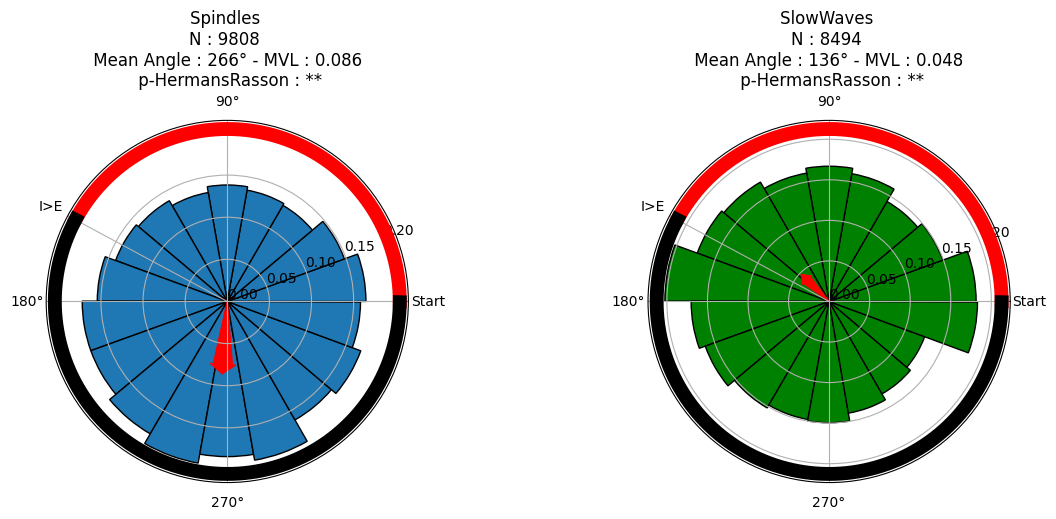

In [5]:
evs = ['Spindles','SlowWaves']
ncols = len(evs)
stage = 'N2'

fig, axs = plt.subplots(ncols=ncols, figsize = (12,5), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, ev in enumerate(evs):
    color = 'g' if c == 1 else None
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = ev, chan = 'Fz', stage = stage)
    print(angles.size)
    circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio)
    ax.set_title(f'{ev} \n' + ax.get_title())
fig.savefig(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'figs' / 'spindles_slowwaves_coupling.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

# SPINDLES SLOW FAST : FZ

5172
4636


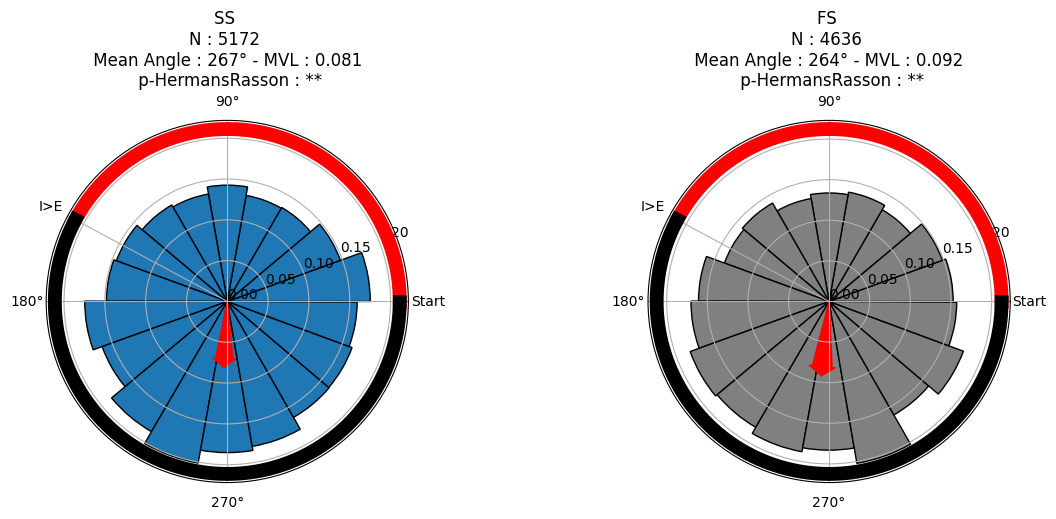

In [6]:
speeds = ['SS','FS']
ncols = len(speeds)
stage = 'N2'

fig, axs = plt.subplots(ncols=ncols, figsize = (12,5), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, speed in enumerate(speeds):
    color = 'grey' if c == 1 else None
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage =stage, ratio_df = ratio_df)
    angles = load_angles(event = 'Spindles', chan = 'Fz', stage = stage, speed = speed)
    print(angles.size)
    circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio)
    ax.set_title(f'{speed} \n' + ax.get_title())
fig.savefig(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'figs' / 'spindles_coupling_speeds.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

# NIGHT QUARTILE SPINDLE PHASING : FZ - N2

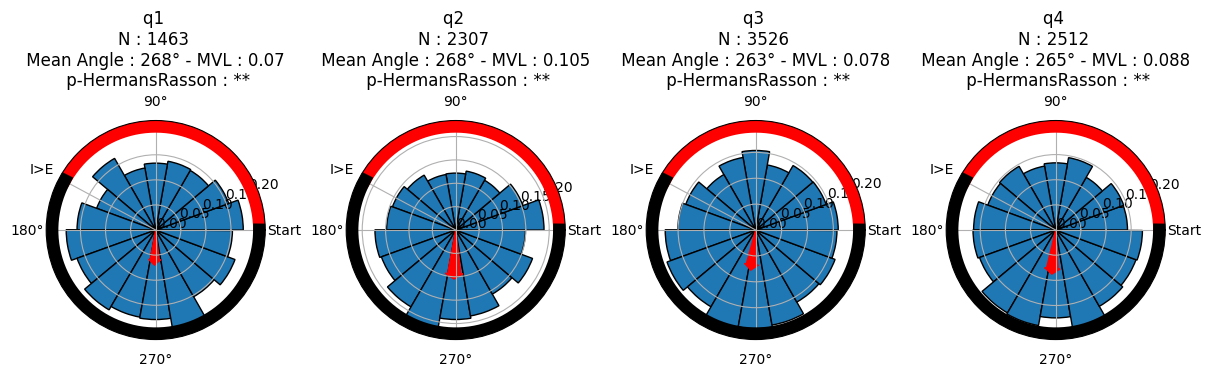

In [7]:
qs = ['q1','q2','q3','q4']
ncols = len(qs)
stage = 'N2'

fig, axs = plt.subplots(ncols=ncols, figsize = (12,5), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, q in enumerate(qs):
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
    angles = load_angles(event = 'Spindles', chan = 'Fz', quart_night = q, speed = '*', stage = stage)
    circular_plot_angles(angles, with_title = True, ax = ax, ratio_plot=ratio)
    ax.set_title(f'{q} \n' + ax.get_title())
fig.savefig(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'figs' / 'spindles_coupling_quartnight.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

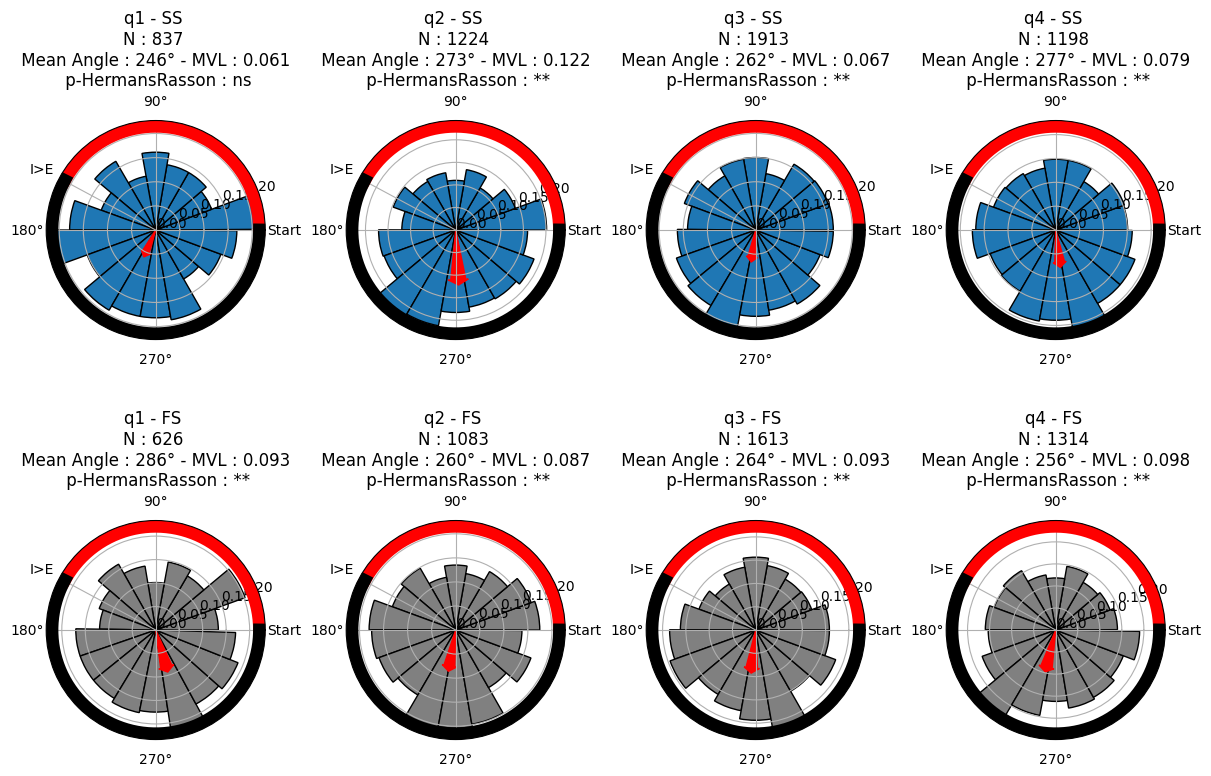

In [8]:
qs = ['q1','q2','q3','q4']
speeds = ['SS','FS']
stage = 'N2'

ncols = len(qs)
nrows = len(speeds)

fig, axs = plt.subplots(nrows = nrows, ncols=ncols, figsize = (12,8), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, q in enumerate(qs):
    for r, speed in enumerate(speeds):
        color = 'grey' if r == 1 else None
        ax = axs[r,c]
        ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
        angles = load_angles(event = 'Spindles', chan = 'Fz', quart_night = q, speed = speed, stage = stage)
        circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio)
        ax.set_title(f'{q} - {speed} \n' + ax.get_title())
        
fig.savefig(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'figs' / 'spindles_coupling_quartnight_speed.tif', dpi = 300, bbox_inches = 'tight')
plt.show()

# CO-OCCURING vs NOT COOCCURING ALL ELECTRODES

### Warning, this may take a long computation time

1847


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 242.57it/s]


97260


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:30<00:00,  8.71s/it]


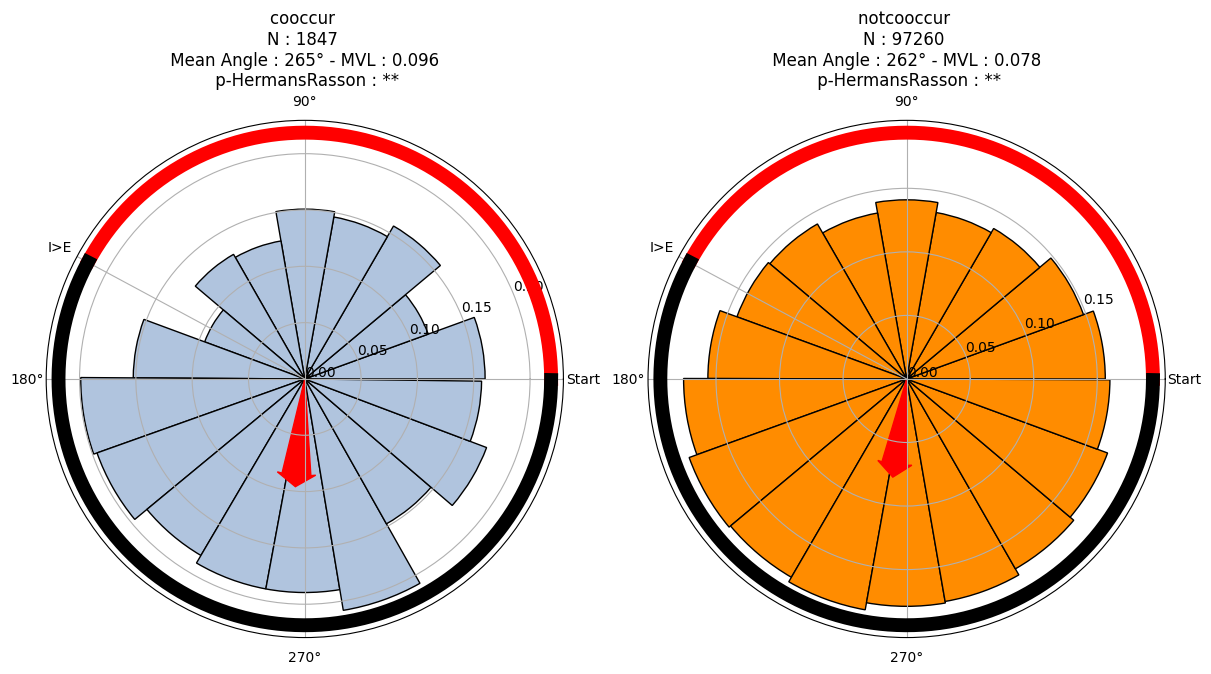

In [9]:
coocs = ['cooccur','notcooccur']
stage = 'N2'

ncols = len(coocs)

fig, axs = plt.subplots(ncols=ncols, figsize = (12,8), subplot_kw=dict(projection = 'polar'), constrained_layout = True)
for c, cooc in enumerate(coocs):
    color = 'darkorange' if c == 1 else 'lightsteelblue'
    ax = axs[c]
    ratio = get_respi_ratio(subject = '*', stage = stage, ratio_df = ratio_df)
    angles = load_angles(event = 'Spindles', stage = stage, cooccuring = cooc)
    print(angles.size)
    circular_plot_angles(angles, with_title = True, ax = ax, color = color, ratio_plot = ratio, progress_bar = True)
    ax.set_title(f'{cooc} \n' + ax.get_title())
        
fig.savefig(base_folder / 'autres' / 'article_N20' / 'clin_neurophy_submission2' / 'figs' / 'spindles_coupling_cooccuring.tif', dpi = 300, bbox_inches = 'tight')
plt.show()